In [56]:
import torch
import torchvision
import torch.nn as nn
from torchvision.datasets import  FashionMNIST
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.nn.functional as F
import random


## Hyperparams

In [9]:
lr = .001
batch_size = 256
in_l = 784
hid_l  =32
op_l = 10


## Downloading and splitting the data into train, test and validation sets.

In [10]:
train_ds = FashionMNIST(root = "D:\Learning\ML\RL\TORCH\FashionFashionFashionMNIST_data", download=True , transform=transforms.ToTensor())
test_ds = FashionMNIST(root = "D:\Learning\ML\RL\TORCH\FashionFashionMNIST_data",download= True, train=False , transform=transforms.ToTensor())
train_ds , val_ds = random_split(train_ds , [50000, 10000])
len(train_ds), len(val_ds)


(50000, 10000)

## Data Loading - Splitting the data into batches

In [11]:
train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True, num_workers=4,pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=4 , pin_memory=True)

image shape :  torch.Size([256, 1, 28, 28])


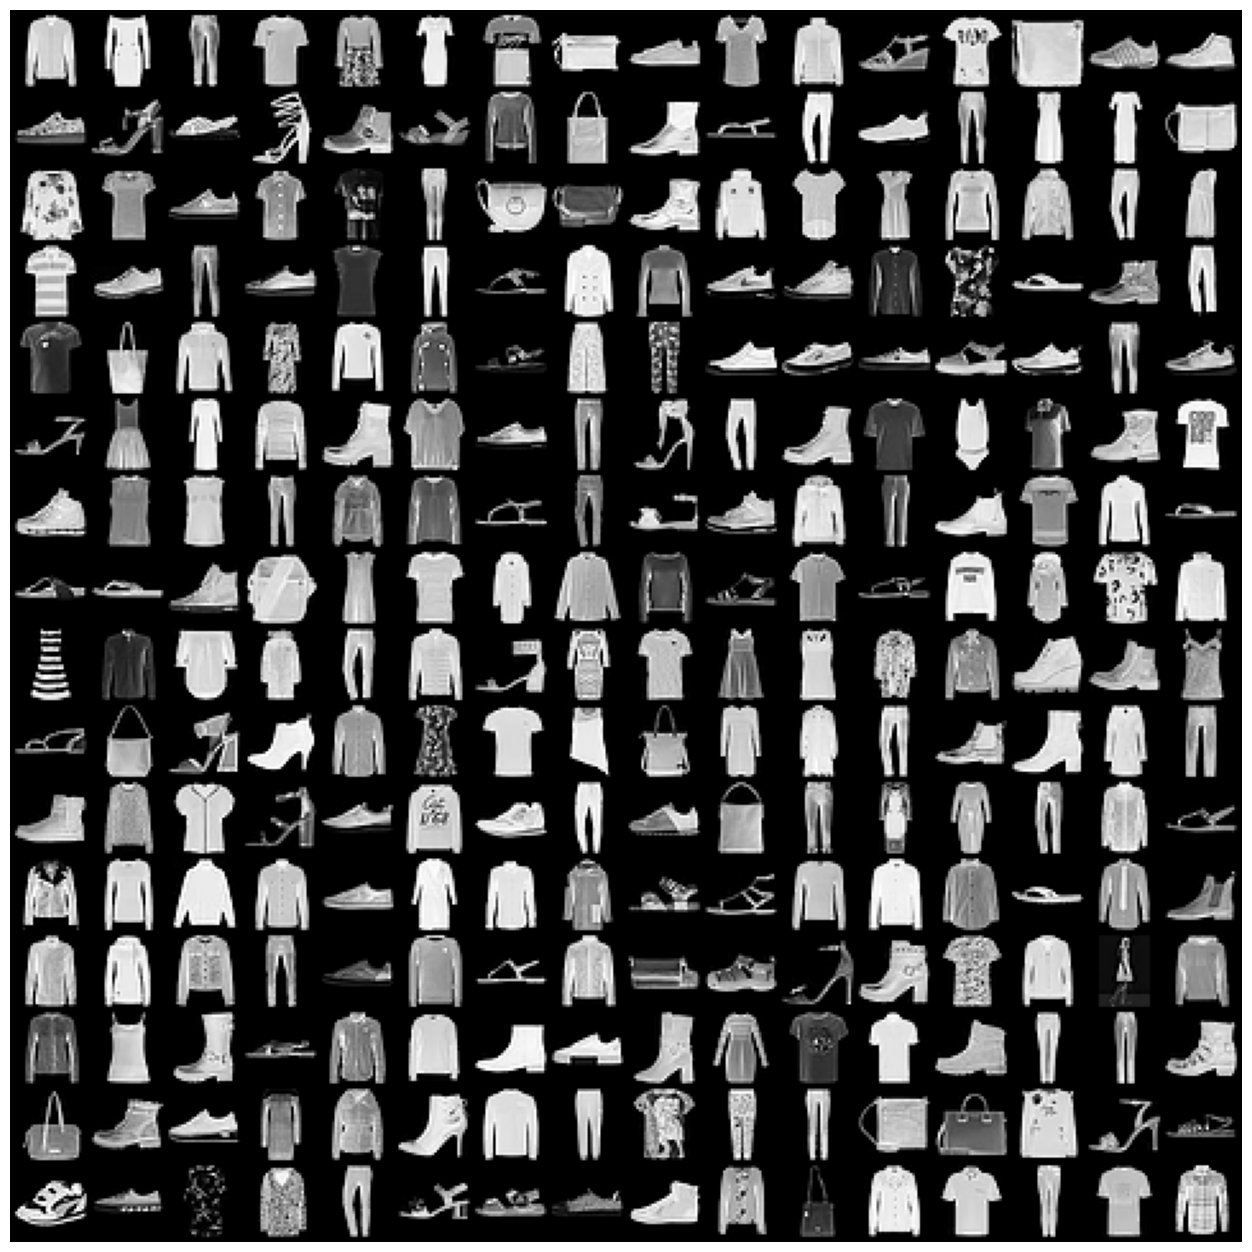

In [12]:
for images, labels in train_loader:
    print("image shape : ", images.shape)
    plt.figure(figsize=(16,16))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
    break

## Model\

In [13]:
def accuracy(out, labels):
    _, preds = torch.max(out, dim=1)    
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))
class MnistNN(nn.Module):
    
    def __init__(self,inp_l  , hid_l , op_l ) -> None:
        super(MnistNN, self).__init__()
        self.linear1 = nn.Linear(inp_l, hid_l)
        self.linear2 = nn.Linear(hid_l, op_l)
    # NN Layer
    def forward(self,xb):
        xb = xb.view(xb.size(0),-1)
        out = self.linear1(xb)
        out = F.relu(out)
        out= self.linear2(out)
        return out
    #LOSS for each batch     ==== returns loss
    def training_step(self, batch): 
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    #VALIDATES for each val ds each batch ==== returns loss and acc
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc=  accuracy(out, labels)
        return {"valLoss" : loss , "valAcc": acc}
    # AVG  all the LOSS and ACC for Valiadtion set  for each batch
    def validation_epoch_end(self, outputs):
        batch_loss = [X["valLoss"] for X in outputs]
        batch_acc = [X["valAcc"] for X in outputs]
        epoch_loss  = torch.stack(batch_loss).mean()
        epoch_acc  = torch.stack(batch_acc).mean()
        return {"valLoss" : epoch_loss , "valAcc" : epoch_acc}
    # AVG all the ACC and LOSS for a single EPOCH
    def epoch_end(self, epoch,result):
        print("Epoch [ {}],val_loss : {:.4f} , val_acc {:.4f}".format(epoch, result["valLoss"] , result["valAcc"]))




In [14]:
model = MnistNN(in_l,hid_l,op_l)

In [15]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


## CUDA +_+

In [16]:
torch.cuda.is_available()

True

In [17]:
#returns cuda or cpu 
def get_def_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

device = get_def_device()
device


device(type='cuda')

In [18]:
# changes to to_device
def to_device(data , device):
    if isinstance(data , (tuple, list)):
        return[to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

In [19]:
for images, labels in train_loader:
    print(images.shape , images.device)
    images  = to_device(images, device)
    print(images.shape , images.device)

    
    break


torch.Size([256, 1, 28, 28]) cpu
torch.Size([256, 1, 28, 28]) cuda:0


--- move the loaded data to GPU


In [20]:
class DeviceDataLoader():
    def __init__(self,dl , device):
        self.dl=dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
        

In [21]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

## Training the model

In [22]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [23]:
def fit(epochs, lr, model , train_loader , val_loader , opt_fn = torch.optim.SGD):
    history = [ ]
    optimiser = opt_fn(model.parameters(), lr)

    for epoch in range(epochs):

        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()

        result = evaluate(model , val_loader)
        model.epoch_end(epoch,result)
        history.append(result)

    return history

In [24]:
model = MnistNN(in_l,hid_l , op_l)
to_device(model, device)

MnistNN(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [25]:
for images, labels in train_loader:
    out= model(images)
    acc = accuracy(out, labels)
    loss = F.cross_entropy(out, labels)
    break

print("loss"  ,loss.item() , "accuracy " , acc, "\n out shape  : ", out.shape, "\n sample out : " , out[:2].data)

loss 2.3368289470672607 accuracy  tensor(0.0781) 
 out shape  :  torch.Size([256, 10]) 
 sample out :  tensor([[ 0.1219,  0.0219,  0.0918,  0.0794, -0.1518,  0.1715, -0.0751,  0.0791,
          0.0448,  0.0840],
        [ 0.2952,  0.1787,  0.1837,  0.0192, -0.1851,  0.3003,  0.0337,  0.1148,
          0.1723,  0.1636]], device='cuda:0')


In [26]:
history = [evaluate (model,val_loader)]
history

[{'valLoss': tensor(2.3356, device='cuda:0', grad_fn=<MeanBackward0>),
  'valAcc': tensor(0.0864)}]

In [27]:
history += fit(5,.5,model, train_loader,val_loader)


Epoch [ 0],val_loss : 1.0315 , val_acc 0.6085
Epoch [ 1],val_loss : 0.6568 , val_acc 0.7234
Epoch [ 2],val_loss : 0.6027 , val_acc 0.7688
Epoch [ 3],val_loss : 0.5046 , val_acc 0.8228
Epoch [ 4],val_loss : 0.4661 , val_acc 0.8319


In [28]:
history += fit(7,.1,model, train_loader,val_loader)


Epoch [ 0],val_loss : 0.4473 , val_acc 0.8423
Epoch [ 1],val_loss : 0.4478 , val_acc 0.8421
Epoch [ 2],val_loss : 0.4458 , val_acc 0.8458
Epoch [ 3],val_loss : 0.4419 , val_acc 0.8471
Epoch [ 4],val_loss : 0.4370 , val_acc 0.8514
Epoch [ 5],val_loss : 0.4370 , val_acc 0.8514
Epoch [ 6],val_loss : 0.4291 , val_acc 0.8515


In [29]:
history += fit(5,.34,model, train_loader,val_loader)


Epoch [ 0],val_loss : 0.4722 , val_acc 0.8353
Epoch [ 1],val_loss : 0.4715 , val_acc 0.8353
Epoch [ 2],val_loss : 0.4710 , val_acc 0.8308
Epoch [ 3],val_loss : 0.4915 , val_acc 0.8317
Epoch [ 4],val_loss : 0.4397 , val_acc 0.8430


In [30]:
model.to('cuda')

MnistNN(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [31]:
history += fit(10,.1,model, train_loader,val_loader)


Epoch [ 0],val_loss : 0.4051 , val_acc 0.8615
Epoch [ 1],val_loss : 0.4041 , val_acc 0.8623
Epoch [ 2],val_loss : 0.4062 , val_acc 0.8583
Epoch [ 3],val_loss : 0.4085 , val_acc 0.8530
Epoch [ 4],val_loss : 0.4031 , val_acc 0.8576
Epoch [ 5],val_loss : 0.4040 , val_acc 0.8597
Epoch [ 6],val_loss : 0.4208 , val_acc 0.8467
Epoch [ 7],val_loss : 0.3951 , val_acc 0.8624
Epoch [ 8],val_loss : 0.4147 , val_acc 0.8536
Epoch [ 9],val_loss : 0.4082 , val_acc 0.8579


## Saving the model

In [32]:
torch.save(model.state_dict(), "mnist.pth")

## loading the model

In [33]:
model  = MnistNN(in_l,hid_l,op_l)
model.load_state_dict(torch.load("mnist.pth"))

<All keys matched successfully>

In [34]:
history

[{'valLoss': tensor(2.3356, device='cuda:0', grad_fn=<MeanBackward0>),
  'valAcc': tensor(0.0864)},
 {'valLoss': tensor(1.0315, device='cuda:0', grad_fn=<MeanBackward0>),
  'valAcc': tensor(0.6085)},
 {'valLoss': tensor(0.6568, device='cuda:0', grad_fn=<MeanBackward0>),
  'valAcc': tensor(0.7234)},
 {'valLoss': tensor(0.6027, device='cuda:0', grad_fn=<MeanBackward0>),
  'valAcc': tensor(0.7688)},
 {'valLoss': tensor(0.5046, device='cuda:0', grad_fn=<MeanBackward0>),
  'valAcc': tensor(0.8228)},
 {'valLoss': tensor(0.4661, device='cuda:0', grad_fn=<MeanBackward0>),
  'valAcc': tensor(0.8319)},
 {'valLoss': tensor(0.4473, device='cuda:0', grad_fn=<MeanBackward0>),
  'valAcc': tensor(0.8423)},
 {'valLoss': tensor(0.4478, device='cuda:0', grad_fn=<MeanBackward0>),
  'valAcc': tensor(0.8421)},
 {'valLoss': tensor(0.4458, device='cuda:0', grad_fn=<MeanBackward0>),
  'valAcc': tensor(0.8458)},
 {'valLoss': tensor(0.4419, device='cuda:0', grad_fn=<MeanBackward0>),
  'valAcc': tensor(0.8471)},


Text(0, 0.5, 'Loss')

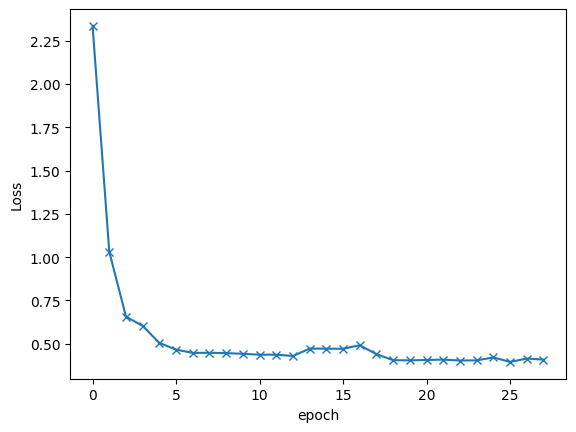

In [35]:
losses = [x["valLoss"].cpu().detach().numpy() for x in history]
plt.plot(losses, "-x")
plt.xlabel("epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

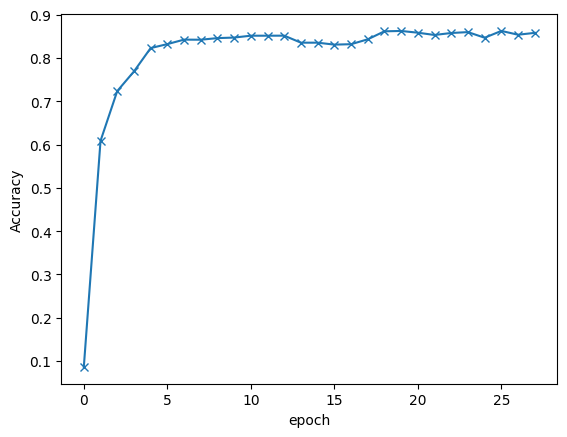

In [36]:
acc = [x["valAcc"].cpu().detach().numpy() for x in history]
plt.plot(acc, "-x")
plt.xlabel("epoch")
plt.ylabel("Accuracy")

## predict

In [37]:
model.to('cuda')

MnistNN(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [38]:
def predict(img, model):
    imge = to_device(img.unsqueeze(0),device)
    out = model(imge)
    conf,preds  = torch.max(out , dim=1)
    
    return preds[0]


In [39]:
images, labels = test_ds[0]
predict(images , model),labels

(tensor(9, device='cuda:0'), 9)

In [40]:
lst= []
for xb in test_ds:
    images , labels  = xb
    x=predict(images,model)
    lst.append(x)

sum(lst)/len(test_ds)



tensor(4.3888, device='cuda:0')

In [41]:
test_loader = DeviceDataLoader(DataLoader(test_ds,256 ,shuffle=True , num_workers=4,pin_memory=True) , device)
evaluate(model,train_loader)

{'valLoss': tensor(0.3770, device='cuda:0', grad_fn=<MeanBackward0>),
 'valAcc': tensor(0.8667)}

p tensor(6, device='cuda:0')
ll tensor(0, device='cuda:0')
p tensor(4, device='cuda:0')
ll tensor(4, device='cuda:0')


c:\Users\SURYA\anaconda3\envs\tf\lib\site-packages\torch\_tensor.py:893: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


p tensor(3, device='cuda:0')
ll tensor(3, device='cuda:0')
p tensor(0, device='cuda:0')
ll tensor(0, device='cuda:0')
p tensor(4, device='cuda:0')
ll tensor(4, device='cuda:0')
p tensor(4, device='cuda:0')
ll tensor(1, device='cuda:0')
p tensor(3, device='cuda:0')
ll tensor(3, device='cuda:0')
p tensor(0, device='cuda:0')
ll tensor(0, device='cuda:0')
p tensor(0, device='cuda:0')
ll tensor(0, device='cuda:0')
p tensor(7, device='cuda:0')
ll tensor(7, device='cuda:0')


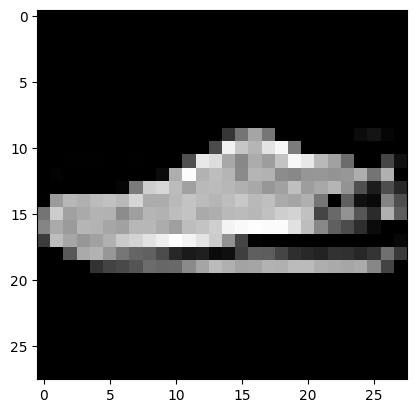

In [59]:
i = 0
for images , labels in test_loader:
    i+=1
    k=random.randint(0,255)
    print( "p",predict(images[k], model))
    
    plt.imshow(images[k].cpu().resize(28,28) , cmap = "gray")
    print("ll",labels[k])
    if(i==10):
        break
    
    
    